In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

In [2]:
PKLPATH = Path("/home/boittier/Documents/phd/ff_energy/pickles/")
pd.read_csv(PKLPATH / "ELECm_water_cluster_lj_elec.csv")

,Unnamed: 0,target,residuals,vals
0,test0,-89.677734,-5.990310,-83.687420
1,test1,-54.121080,0.876040,-54.997120
2,test10,-52.970302,-3.259021,-49.711280
3,test100,-43.162995,5.054619,-48.217613
4,test101,-55.907430,1.223963,-57.131393
...,...,...,...,...
495,test95,-69.659773,-2.103957,-67.555820
496,test96,-72.332202,1.224759,-73.556960
497,test97,-68.158347,-1.216300,-66.942050
498,test98,-65.536420,-4.302479,-61.233940


#  Old FF objects

In [67]:
FFOBJ = pd.read_pickle(
    "/home/boittier/Documents/phd/ff_energy/pickles/ELECppol_water_cluster_lj_fitted.pkl")

In [68]:
FFOBJ.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,ELECci,ELECp,ELECm,ELECk,ELECnull,ELECppol,ELECmpol,ELECkpol,ELECnullpol,DUMMY
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-173.022645,-86.50353,-109.15129,-104.54998,-0.0,-102.879193,-125.526953,-120.925643,-16.375663,0.0
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-105.096240,-55.44306,-67.34370,-63.45565,-0.0,-63.017501,-74.918141,-71.030091,-7.574441,0.0
test10,-108.320600,test10,22.55630,-52.42873,8.46527,test10,-1527.152885,test10,20,-1527.237300,...,-108.320600,-52.42873,-62.11265,-62.96512,-0.0,-60.745846,-70.429766,-71.282236,-8.317116,0.0
test100,-120.244324,test100,23.76369,-66.03681,19.45476,test100,-1527.141372,test100,20,-1527.210157,...,-120.244324,-66.03681,-72.15766,-66.67887,-0.0,-74.372871,-80.493721,-75.014931,-8.336061,0.0
test101,-125.221598,test101,19.42966,-67.62729,15.89952,test101,-1527.160675,test101,20,-1527.249770,...,-125.221598,-67.62729,-77.04152,-74.99933,-0.0,-75.897445,-85.311675,-83.269485,-8.270155,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test95,-123.917572,test95,24.31345,-71.02166,12.12799,test95,-1527.135077,test95,20,-1527.246088,...,-123.917572,-71.02166,-83.76700,-76.31560,-0.0,-82.682985,-95.428325,-87.976925,-11.661325,0.0
test96,-163.434955,test96,25.18816,-78.76038,18.10955,test96,-1527.131558,test96,20,-1527.246828,...,-163.434955,-78.76038,-97.21214,-93.72871,-0.0,-93.362538,-111.814298,-108.330868,-14.602158,0.0
test97,-132.990408,test97,22.23548,-71.50784,10.84849,test97,-1527.149964,test97,20,-1527.258582,...,-132.990408,-71.50784,-82.54423,-79.19230,-0.0,-83.690078,-94.726468,-91.374538,-12.182238,0.0
test98,-114.076388,test98,19.89380,-59.12743,9.63436,test98,-1527.160158,test98,20,-1527.264598,...,-114.076388,-59.12743,-74.18664,-73.12057,-0.0,-68.149171,-83.208381,-82.142311,-9.021741,0.0


In [69]:
# {k:v for k,v in FFOBJ.dists.items() if k in train_id}.values()

In [71]:
FFOBJ.data.keys()

Index(['ECOL', 'KEY', 'TOTAL', 'ELEC', 'VDW', 'KEY', 'M_ENERGY', 'KEY',
       'n_monomers', 'C_ENERGY', 'n_pairs', 'intE', 'P_intE', 'm_E_tot',
       'p_m_E_tot', 'C_ENERGY_kcalmol', 'ELECpol', 'ELECci', 'ELECp', 'ELECm',
       'ELECk', 'ELECnull', 'ELECppol', 'ELECmpol', 'ELECkpol', 'ELECnullpol',
       'DUMMY'],
      dtype='object')

In [72]:
train_id = list(FFOBJ.data[:400].index)

In [73]:
structure = "water_cluster"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)
dists = {str(s.name).split(".")[0]: s.distances for s in structs}
struct_data = structs[0]

def test_train_results(elec):

    #  train
    ljpcff = FF(
        FFOBJ.data[:400], # pd.DataFrame
        dists, #
        LJ, #
        LJ_bound, # tuple
        struct_data, 
        elec=elec,
        intE="intE",
    )
    #  set the targets
    ljpcff.num_segments = len(FFOBJ.data[:400])
    print("Nsegments", ljpcff.num_segments)
    ljpcff.set_targets()

    # fit
    ljpcff_fit = fit_repeat(ljpcff,
                 10,
                 "test",
                 loss="jax",
                quiet=False)

    ljpcff_test = FF(
        FFOBJ.data[400:], # pd.DataFrame
        dists, #
        LJ, #
        LJ_bound, # tuple
        struct_data, 
        elec=elec,
        intE="intE",
    )
    #  set the targets
    ljpcff_test.num_segments = len(FFOBJ.data[400:])
    print("Nsegments", ljpcff_test.num_segments)
    ljpcff_test.set_targets()

    test_rmse = np.sqrt(calc_rmse(ljpcff_test.targets, 
                      ljpcff_test.eval_jax(ljpcff.get_best_parm())[0]))
    train_rmse = np.sqrt(calc_rmse(ljpcff.targets, 
                      ljpcff.eval_jax(ljpcff.get_best_parm())[0]))
    
    train_df = pd.DataFrame({"residuals": ljpcff.targets -
                      ljpcff.eval_jax(ljpcff.get_best_parm())[0] })
    train_std_error = train_df["residuals"].std()
    
    test_df = pd.DataFrame({"residuals": ljpcff_test.targets -
                      ljpcff_test.eval_jax(ljpcff.get_best_parm())[0] })
    test_std_error = test_df["residuals"].std()
    
    return {"test_RMSE": test_rmse,
           "train_RMSE": train_rmse,
           "test_stderr": test_std_error,
           "train_stderr": train_std_error,
           "parms": ljpcff.get_best_parm()}
    
    

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500


In [62]:
test_train_results("ELECm")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.2024481268165492, 2.842687553593144, 0.9185767926719643, 0.19631818438811122]
sig [4.4048962536330984, 5.045135680409693, 5.685375107186288]
ep [0.9185767926719643, 0.424656718018701, 0.19631818438811122]
epsilons {'HT': 0.9185767926719643, 'OT

{'test_RMSE': 3.7684696,
 'train_RMSE': 4.2076497,
 'test_stderr': 3.5138855,
 'train_stderr': 4.2126994,
 'parms': array([0.21425026, 1.82757288, 0.09785659, 0.09999743])}

In [63]:
test_train_results("ELECp")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.8187530811401276, 3.6595170437683584, 0.11288370298205197, 0.12656626269243715]
sig [7.637506162280255, 7.4782701249084855, 7.319034087536717]
ep [0.11288370298205197, 0.11952936210538999, 0.12656626269243715]
epsilons {'HT': 0.1128837029820519

{'test_RMSE': 5.3805466,
 'train_RMSE': 5.7420163,
 'test_stderr': 4.880017,
 'train_stderr': 5.7454176,
 'parms': array([0.36086188, 1.74339978, 0.1       , 0.09999996])}

In [64]:
test_train_results("ELECci")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [0.812551266962381, 2.0220935837827887, 0.05092308216191527, 0.10042752116159756]
sig [1.625102533924762, 2.83464485074517, 4.044187167565577]
ep [0.05092308216191527, 0.07151278844674928, 0.10042752116159756]
epsilons {'HT': 0.05092308216191527, 

{'test_RMSE': 4.2929873,
 'train_RMSE': 4.670851,
 'test_stderr': 4.272601,
 'train_stderr': 4.6763444,
 'parms': array([0.1707751 , 2.37060759, 0.0166763 , 0.00737491])}

In [74]:
test_train_results("ELECppol")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.7594242920376075, 2.426816117834264, 0.5216041680366148, 0.7804398252349306]
sig [5.518848584075215, 5.186240409871871, 4.853632235668528]
ep [0.5216041680366148, 0.6380287342622643, 0.7804398252349306]
epsilons {'HT': 0.5216041680366148, 'OT':

{'test_RMSE': 4.5038233,
 'train_RMSE': 4.534009,
 'test_stderr': 4.2162504,
 'train_stderr': 4.5387616,
 'parms': array([0.25240562, 1.81498918, 0.0999932 , 0.1       ])}

In [75]:
test_train_results("ELECmpol")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [0.7924765940527622, 2.770674905577956, 0.9089066527506441, 0.9561006147884984]
sig [1.5849531881055243, 3.563151499630718, 5.541349811155912]
ep [0.9089066527506441, 0.9322050254532245, 0.9561006147884984]
epsilons {'HT': 0.9089066527506441, 'OT'

{'test_RMSE': 3.018429,
 'train_RMSE': 3.1007745,
 'test_stderr': 2.8516648,
 'train_stderr': 3.1043844,
 'parms': array([0.20322977, 1.93630213, 0.1       , 0.05341145])}

In [76]:
test_train_results("ELECpol")

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test0     -89.677734
test1     -54.121080
test10    -52.970302
test100   -43.162995
test101   -55.907430
             ...    
test454   -46.182878
test455   -49.467078
test456   -47.746496
test457   -46.248345
test458   -52.866080
Name: intE, Length: 400, dtype: float64
count    400.000000
mean     -60.201458
std       13.275178
min      -97.496735
25%      -68.618479
50%      -60.560076
75%      -50.901266
max      -25.015840
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [0.9328246740773787, 2.411185702864974, 0.14558103184723123, 0.43465779618702727]
sig [1.8656493481547574, 3.344010376942353, 4.822371405729948]
ep [0.14558103184723123, 0.2515510494300331, 0.43465779618702727]
epsilons {'HT': 0.14558103184723123,

{'test_RMSE': 3.9686885,
 'train_RMSE': 3.980608,
 'test_stderr': 3.9813101,
 'train_stderr': 3.9852195,
 'parms': array([3.89445142e-01, 2.71965584e+00, 1.00000000e-03, 1.46036512e-03])}

In [50]:
# FFOBJ.bounds

In [28]:
test_id = list(FFOBJ.data[400:].index)

In [41]:
structure = "water_cluster"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)
dists = {str(s.name).split(".")[0]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500


In [49]:
# dists.keys()

In [51]:
ljpcff_test = FF(
    FFOBJ.data[400:], # pd.DataFrame
    dists, #
    LJ, #
    LJ_bound, # tuple
    struct_data, 
    elec="ELECm",
    intE="intE",
)
#  set the targets
ljpcff_test.num_segments = len(FFOBJ.data[400:])
print("Nsegments", ljpcff_test.num_segments)
ljpcff_test.set_targets()

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
test459   -30.904065
test46    -42.578702
test460   -48.682247
test461   -48.130446
test462   -49.866578
             ...    
test95    -69.659773
test96    -72.332202
test97    -68.158347
test98    -65.536420
test99    -59.492637
Name: intE, Length: 100, dtype: float64
count    100.000000
mean     -60.298165
std       13.083844
min     -102.618427
25%      -68.879782
50%      -61.994711
75%      -51.886639
max      -27.267321
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.416799083713968, 3.109840149311432, 0.7172068984977175, 0.6685294971084154]
sig [6.833598167427936, 6.526639233025399, 6.219680298622864]
ep [0.7172068984977175, 0.6924405874696871, 0.6685294971084154]
epsilons {'HT': 0.7172068984977175, 'OT': 

In [52]:
ljpcff.get_best_parm()

array([0.21275144, 1.82770898, 0.09999255, 0.1       ])

In [57]:
np.sqrt(calc_rmse(ljpcff_test.targets, ljpcff_test.eval_jax(ljpcff.get_best_parm())[0]))

3.7680595

Array([14.783577  , 12.725929  , 16.188183  , 11.037674  , 22.686722  ,
       18.048935  , 19.26942   , 17.273605  , 15.11475   , 14.522156  ,
       30.078674  , 27.714928  , 15.948528  , 10.481838  , 13.243919  ,
       24.566505  , 30.359535  , 11.275055  , 29.607063  ,  4.355446  ,
       27.197144  , 15.069069  , 28.245049  , 20.980652  , 18.854347  ,
       17.678017  , 16.451057  , 13.300102  , 20.984726  , 22.699577  ,
       34.980686  , 23.621117  , 18.068005  , 38.551483  , 23.254787  ,
       26.18647   , 27.369484  , 20.21267   , 14.848167  , 18.160713  ,
       18.416824  , 19.246643  , 33.89592   , 21.769783  , 22.040657  ,
       15.9541855 , 10.040894  ,  8.479095  , 20.399414  , 24.175312  ,
       18.32457   , 11.000427  , 10.41011   , 23.891602  , 23.41217   ,
       25.029816  , 31.580635  , 23.270264  , 30.513485  , 16.570984  ,
       29.304176  , 15.133156  , 19.776985  , 14.246727  , 20.383     ,
       25.393585  , 12.936443  , 27.036587  , 11.500202  , 22.60

In [10]:
FFOBJ.get_best_parm()

array([0.20554608, 1.82698199, 0.1       , 0.09999999])

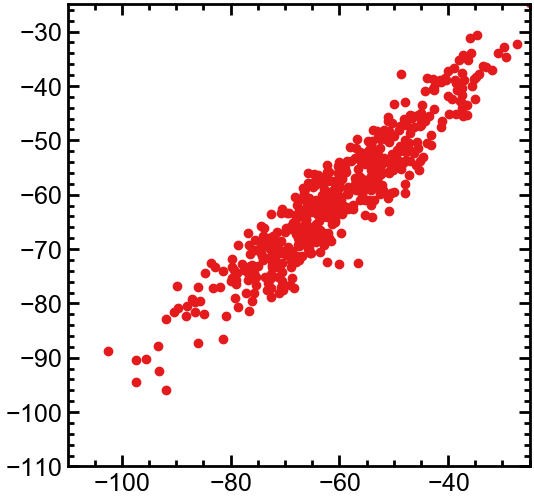

In [11]:
plt.scatter(FFOBJ.targets + FFOBJ.data.ELECm, 
            FFOBJ.opt_results_df[0][0] + FFOBJ.data.ELECm)
plt.xlim(-110, -25.0)
plt.ylim(-110, -25.0)
plt.gca().set_aspect('equal')

In [12]:
pd.DataFrame(FFOBJ.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
98,16.923601,210,390,0,True,Optimization terminated successfully.,"[0.20561025866928462, 1.8269752019925525, 0.1,...","([[0.20561025866928462, 1.8269752019925525, 0...."
76,16.923601,366,649,0,True,Optimization terminated successfully.,"[0.20554607740806113, 1.8269819922236927, 0.1,...","([[0.20554607740806113, 1.8269819922236927, 0...."
49,16.923603,305,537,0,True,Optimization terminated successfully.,"[0.20560333144095233, 1.8269726506907005, 0.1,...","([[0.20560333144095233, 1.8269726506907005, 0...."
55,16.923607,476,831,0,True,Optimization terminated successfully.,"[0.20536021674418842, 1.8269788951431205, 0.1,...","([[0.20536021674418842, 1.8269788951431205, 0...."
37,16.923607,623,1065,0,True,Optimization terminated successfully.,"[0.2053553030396817, 1.8269820306291082, 0.1, ...","([[0.2053553030396817, 1.8269820306291082, 0.1..."
...,...,...,...,...,...,...,...,...
89,491.206024,42,121,0,True,Optimization terminated successfully.,"[0.1000000000000002, 0.1, 0.1, 0.0970443965386...","([[0.1000000000000002, 0.1, 0.1, 0.09704439653..."
9,491.206024,38,56,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.1, 0.1]","([[0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], ..."
17,491.206024,50,143,0,True,Optimization terminated successfully.,"[0.1, 0.10609547891854798, 0.08107363771913662...","([[0.1, 0.10609547891854798, 0.081073637719136..."
30,491.206024,18,32,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.1, 0.1]","([[0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], ..."


In [13]:
# ljpcff_fit = fit_repeat(FFOBJ,
#              2,
#              "test",
#              loss="jax",
#             quiet=False)

(array([  5.,  30.,  63., 113.,  97.,  92.,  61.,  25.,  11.,   3.]),
 array([-0.05073166,  4.565597  ,  9.181926  , 13.798255  , 18.414583  ,
        23.030912  , 27.647242  , 32.26357   , 36.879898  , 41.496227  ,
        46.112556  ], dtype=float32),
 <BarContainer object of 10 artists>)

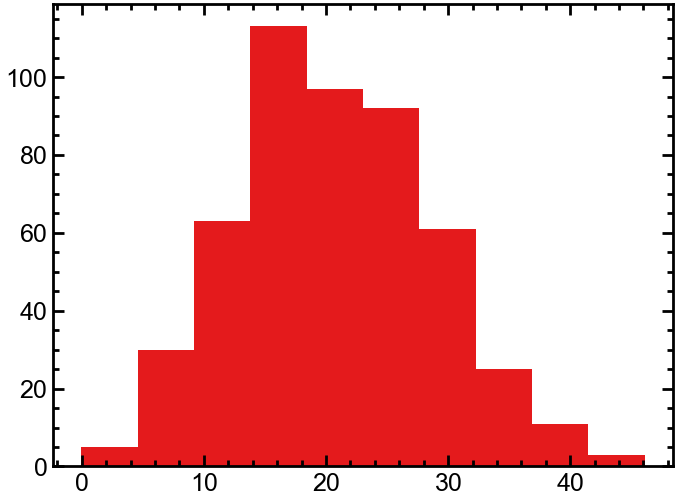

In [14]:
plt.hist(FFOBJ.targets)

# Mike's Data

In [15]:
polE = [-13.711462635646853,
-13.113443990129525,
-12.595535442732256,
-14.095311000002027,
-7.846198418099789,
-12.72244261266701,
-15.185253636471117,
-10.552430608855872,
-16.05838886235921,
-13.43546129222463,
-16.157161381764638,
-14.957260399949945,
-12.250374787929417,
-12.388647565149626,
-12.296129425331827,
-11.34820265559486,
-13.58529778172462,
-10.313607651160595,
-13.382655931830868,
-15.163951361271273,]

#  New structures

In [16]:
data = pd.read_pickle(
    "/home/boittier/Documents/phd/ff_energy/pickles/water_test_pbe0dz_mdcm.pkl")

In [17]:
data_ = data.data
data_.index = data_.KEY

In [18]:
structure = "water_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 21 21


In [19]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test8,12.76158,-112.89762,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462
test18,10.84218,-102.75874,17.58907,test18,-1527.187973,20,-1527.336863,-93.429267,-958408.463825
test13,10.85208,-104.60503,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715
test17,11.90407,-88.26998,20.71719,test17,-1527.186904,20,-1527.291967,-65.927379,-958380.291388
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538
test15,9.39469,-100.67721,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655
test6,10.27872,-124.95550,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428
test12,8.31472,-90.66729,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611


In [20]:
names = ["test0",
"test1",
"test2",
"test3",
"test4",
"test5",
"test6",
"test7",
"test8",
"test9",
"test10",
"test11",
"test12",
"test13",
"test14",
"test15",
"test16",
"test17",
"test18",
"test19",]

In [21]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [22]:
data_.loc[names]

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428
test2,10.63913,-111.02871,21.05558,test2,-1527.187648,20,-1527.331104,-90.019409,-958404.850004
test3,10.50532,-109.56327,24.12367,test3,-1527.188524,20,-1527.334367,-91.516964,-958406.897045
test4,11.82599,-86.29590,13.29071,test4,-1527.183458,20,-1527.289190,-66.347298,-958378.548486
test5,10.79514,-125.32591,32.48558,test5,-1527.188095,20,-1527.329776,-88.904776,-958404.016178
test6,10.27872,-124.95550,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680
test7,11.01626,-92.40308,16.73097,test7,-1527.185562,20,-1527.304014,-74.328571,-958387.850459
test8,12.76158,-112.89762,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462


In [23]:
ljpcff = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(data_)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0    -84.637925
test1    -77.735360
test10   -95.064088
test11   -97.757619
test12   -78.933784
test13   -83.808636
test14   -71.344336
test15   -82.052976
test16   -90.358079
test17   -65.927379
test18   -93.429267
test19   -77.414951
test2    -90.019409
test20   -78.403846
test3    -91.516964
test4    -66.347298
test5    -88.904776
test6    -99.635761
test7    -74.328571
test8    -85.461648
test9    -85.440187
Name: intE, dtype: float64
count    21.000000
mean    -83.739184
std       9.593859
min     -99.635761
25%     -90.358079
50%     -84.637925
75%     -77.735360
max     -65.927379
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.5700054450589414, 3.241599570267252, 0.37339143762129573, 0.942500276618

In [24]:
a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [25]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

In [26]:
# tip3
a,b,c = ljpcff.eval_jax([ 
        0.2245,
        1.7682, 
        0.0460, 
        0.1521, 
])
a,b,c = ljpcff.eval_jax([0.20554608, 1.82698199, 0.1       , 0.09999999])

In [27]:
a

Array([28.382608, 37.97539 , 30.75082 , 26.046896, 18.988691, 27.072355,
       31.726986, 22.128132, 32.447735, 26.33918 , 22.936148, 33.454468,
       26.84205 , 32.003242, 29.794882, 18.517246, 39.680058, 30.847971,
       22.186897, 35.54155 , 29.129536], dtype=float32)

In [28]:
a_,b_,c_ = FFOBJ.eval_jax([0.20554608, 1.82698199, 0.1       , 0.09999999])

In [29]:
# ljpcff.data

(array([2., 1., 0., 4., 6., 1., 3., 1., 1., 2.]),
 array([ 9.329475, 12.064174, 14.798872, 17.533571, 20.268269, 23.002968,
        25.737667, 28.472364, 31.207064, 33.94176 , 36.67646 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

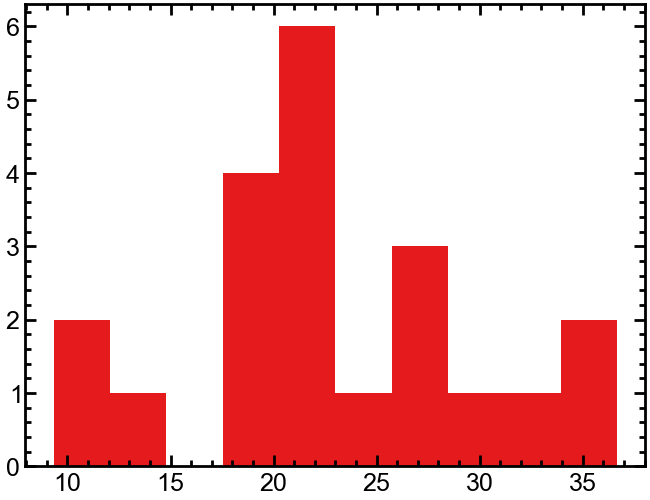

In [30]:
plt.hist(ljpcff.targets)

In [31]:
datacopy = ljpcff.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,28.382608,20.512978
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,37.975391,36.676460
test10,9.92008,-116.48635,24.00860,test10,-1527.187550,20,-1527.339045,-95.064088,-958409.833043,0.0,30.750820,21.422264
test11,10.09932,-110.00557,20.57407,test11,-1527.188313,20,-1527.344101,-97.757619,-958413.005378,0.0,26.046896,12.247948
test12,8.31472,-90.66729,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611,0.0,18.988691,11.733505
test13,10.85208,-104.60503,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715,0.0,27.072355,20.796394
test14,10.79645,-99.59153,24.96655,test14,-1527.189420,20,-1527.303115,-71.344336,-958387.286722,0.0,31.726986,28.247192
test15,9.39469,-100.67721,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655,0.0,22.128132,18.624229
test16,12.72297,-116.87092,25.73819,test16,-1527.184128,20,-1527.328125,-90.358079,-958402.980158,0.0,32.447735,26.512840


In [32]:
datacopy = datacopy.loc[ ["test0",
"test1",
"test2",
"test3",
"test4",
"test5",
"test6",
"test7",
"test8",
"test9",
"test10",
"test11",
"test12",
"test13",
"test14",
"test15",
"test16",
"test17",
"test18",
"test19",]]
datacopy["EPOL"] = polE

In [33]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target,EPOL
KEY,,,,,,,,,,,,,
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,28.382608,20.512978,-13.711463
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,37.975391,36.676460,-13.113444
test2,10.63913,-111.02871,21.05558,test2,-1527.187648,20,-1527.331104,-90.019409,-958404.850004,0.0,26.842051,21.009300,-12.595535
test3,10.50532,-109.56327,24.12367,test3,-1527.188524,20,-1527.334367,-91.516964,-958406.897045,0.0,29.794882,18.046310,-14.095311
test4,11.82599,-86.29590,13.29071,test4,-1527.183458,20,-1527.289190,-66.347298,-958378.548486,0.0,18.517246,19.948601,-7.846198
test5,10.79514,-125.32591,32.48558,test5,-1527.188095,20,-1527.329776,-88.904776,-958404.016178,0.0,39.680058,36.421135,-12.722443
test6,10.27872,-124.95550,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680,0.0,30.847971,25.319740,-15.185254
test7,11.01626,-92.40308,16.73097,test7,-1527.185562,20,-1527.304014,-74.328571,-958387.850459,0.0,22.186897,18.074516,-10.552431
test8,12.76158,-112.89762,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462,0.0,35.541550,27.435974,-16.058389


In [34]:
np.sqrt(calc_rmse(
    ljpcff.data.intE,
    a + ljpcff.data.ELEC
))

7.152322460004618

In [35]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
))

7.636655051962352

In [38]:
np.std(
    ljpcff.data.intE - (
    a + ljpcff.data.ELEC
))

3.884005601608063

In [36]:
np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELECm))

4.113830715622149

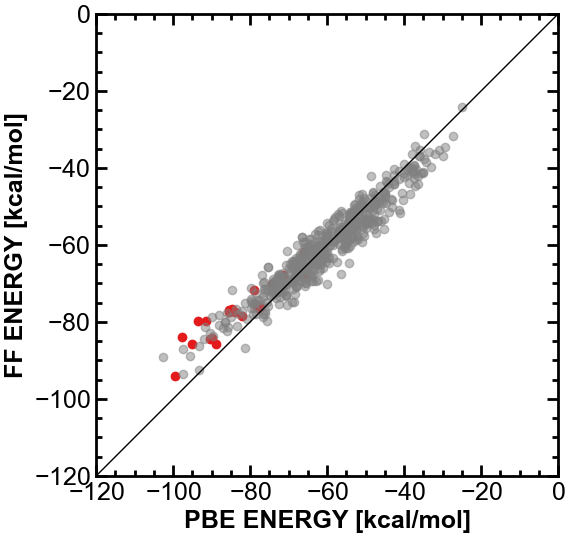

In [37]:
plt.scatter(
            ljpcff.data.intE,
            a + ljpcff.data.ELEC, 
           )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELECm,  c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_mdcm_test.png")

In [64]:
datacopy.ELEC + datacopy.EPOL

KEY
test0    -118.862363
test1    -127.525264
test2    -123.624245
test3    -123.658581
test4     -94.142098
test5    -138.048353
test6    -140.140754
test7    -102.955511
test8    -128.956009
test9    -119.479721
test10   -132.643511
test11   -124.962830
test12   -102.917665
test13   -116.993678
test14   -111.887659
test15   -112.025413
test16   -130.456218
test17    -98.583588
test18   -116.141396
test19   -124.857491
dtype: float64

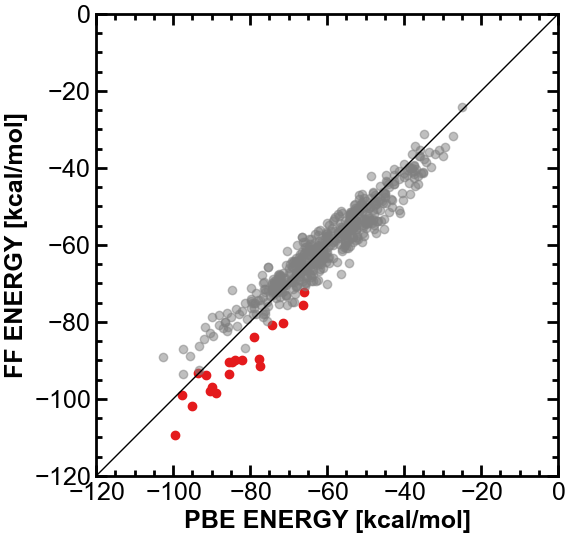

In [88]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELECm, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_mdcm_pol_test.png")